In [1]:
# Lets first  import the dataset and place inside the data folder 
# import kagglehub
# kagglehub.login()

# path = kagglehub.dataset_download("franciscoescobar/satellite-images-of-water-bodies")
# print(f"Dataset downloaded to: {path}")

# Dataset is moved to data folder

# installing other dependencis 
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
# Setting up the imports 
import os 
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Setting up CUDA 
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Creating a custom dataset class for loading satellite images

class WaterBodyDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        '''
        Args:
            images_dir : Directory with satellite images.
            masks_dir : Directory with corresponding water body masks.
            transform : Optional transform to be applied on a sample.
        '''
        
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
        # Just to make sure none of the masks are missing 
        self.image_files= sorted(os.listdir(images_dir))
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        
        img_name = self.image_files[idx]
        
        # Here we load the image and mask
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        mask_path= os.path.join(self.masks_dir, img_name)
        mask= Image.open(mask_path).convert("L") # convert to grayscale 
        
        # Apply transformations just to make variations in the dataset
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        else:
            # Convert image and mask to tensors 
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask
    
                

In [4]:
# Lets see if its working, 
dataset_path = "data/WaterBodiesDataset"
images_path=os.path.join(dataset_path, "Images")
masks_path=os.path.join(dataset_path, "Masks")

transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to tensor
])
dataset = WaterBodyDataset(images_path, masks_path, transform=transform)


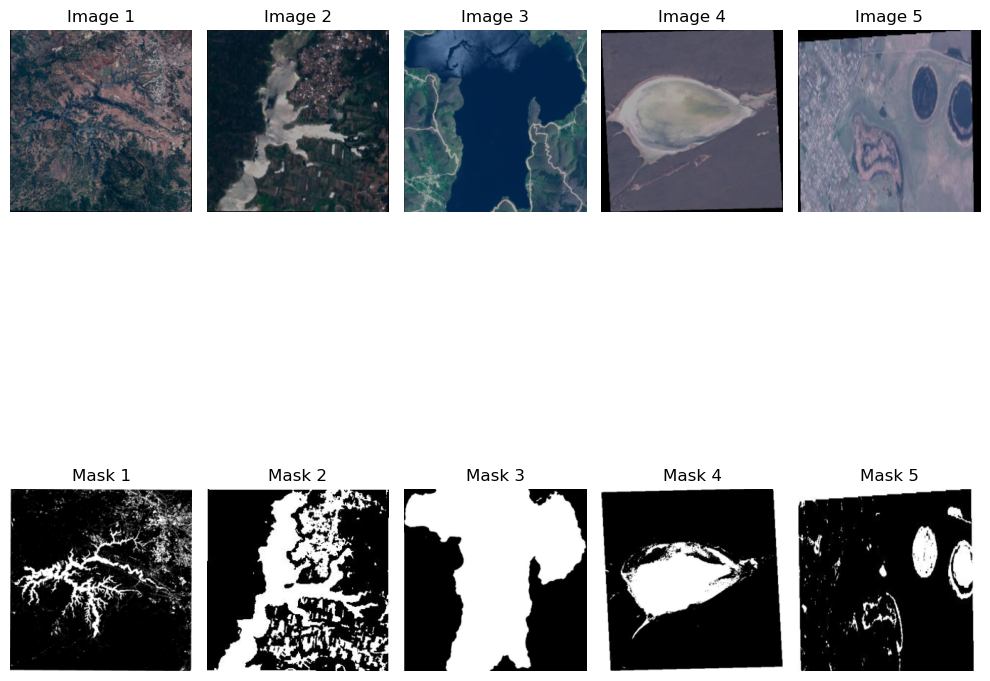

In [5]:
# Lets visualize some images and masks to check if everything is working fine

fig, axs = plt.subplots(2, 5, figsize=(10, 12))

for i in range(5):
    image, mask = dataset[i]
    
    # First we convert tensor to numpy array for visualization
    image_np=image.permute(1, 2, 0).numpy()  # Change from Channel, Height, Width to Height, Width, Channel
    mask_np = mask.squeeze().numpy()  # Remove channel dimension for mask
    
    axs[0, i].imshow(image_np)
    axs[0, i].set_title(f"Image {i+1}")
    axs[0, i].axis('off')
    
    axs[1, i].imshow(mask_np, cmap='gray')
    axs[1, i].set_title(f"Mask {i+1}")
    axs[1, i].axis('off')
    
plt.tight_layout()
plt.show()

In [6]:
# Everything looks superb 
# Now we will go through data preprocessing and DataLoader setup

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# To make random we first shuffle the dataset with indices 
indices = list(range(len(dataset)))
np.random.shuffle(indices)

# lets split into test , train and validation set 
# int so that we dont run into fractional values 
test_size = int(0.15* len(dataset))  # 15% for test
val_size = int(0.15 * len(dataset))  # 15% for validation
train_size = len(dataset) - test_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]



Subset class creates a new dataset that includes only samples at the specified indices.
This is arguablyu more memory efficient than creating a new dataset from the original one. 

In [7]:
# Subsets 
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 1989
Validation samples: 426
Test samples: 426


In [8]:
# DataLoaders 
batch_size = 16  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Images batch shape: torch.Size([16, 3, 256, 256])
Masks batch shape: torch.Size([16, 1, 256, 256])


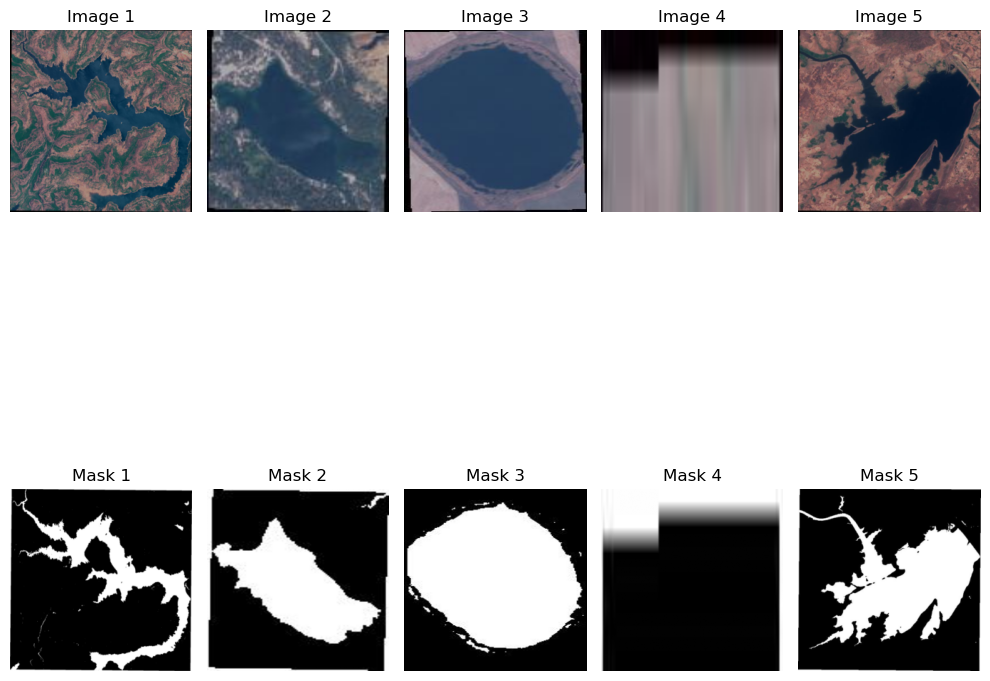

In [9]:
# Checking the dataloader 
images, masks = next(iter(train_loader))
# Checking the shape of images and masks
print(f"Images batch shape: {images.shape}")  # Should be [batch_size, 3, 256, 256]
print(f"Masks batch shape: {masks.shape}")  # Should be [batch_size, 1, 256, 256]
# Visualizing a batch of images and masks
fig, axs = plt.subplots(2, 5, figsize=(10, 12))
for i in range(5):
    image = images[i].permute(1, 2, 0).numpy()  # Change from Channel, Height, Width to Height, Width, Channel
    mask = masks[i].squeeze().numpy()  # Remove channel dimension for mask
    
    axs[0, i].imshow(image)
    axs[0, i].set_title(f"Image {i+1}")
    axs[0, i].axis('off')
    
    axs[1, i].imshow(mask, cmap='gray')
    axs[1, i].set_title(f"Mask {i+1}")
    axs[1, i].axis('off')
plt.tight_layout()

Now comes the important part. We will build the UNet model and train it on the subsets of the datasets we created earlier. 

In [10]:
# First we define DoubleConv class which is a building block for our U-Net architecture.
# This class consists of two convolutional layers followed by batch normalization and ReLU activation.
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv=nn.Sequential(
            # Now we will use two neural network with RELU as activation function
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),#kernel means size of the filter
            nn.BatchNorm2d(out_channels),#this normalizes the output of the convolution layer
            nn.ReLU(inplace=True),#this applies the ReLU activation function in place
            
            # Now the second convolution layer 
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        # It applies the two convolution layers sequentially
    def forward(self, x):
        return self.double_conv(x)

In [11]:
# Now the main U-Net class 
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        
        # Storing down and up sampling paths 
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        
        # MAx pooling and downsampling 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Downsampling path or the Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        # Bottom layer / Bottleneck of UNet 
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2) # doubling the features at the bottleneck
        
        # Upsamping or the Decoder part 
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2,feature,kernel_size=2,stride=2))
            self.ups.append(DoubleConv(feature * 2, feature)) 
            
        # Final part 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        # This layer reduces output channels to the desired number i.e 1 for binary segmentation 
        
    def forward(self, x):
        skip_connections = [] # to store skip connections for the decoder path
        
        # Max pooling to reduce dimension before next layer
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        # again the bottleneck layer
        x = self.bottleneck(x)
        
        # reverse the order for upsampling
        skip_connections = skip_connections[::-1]
        
        # Decoding 
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i // 2]
            
        concatenate_skip = torch.cat((x, skip_connection), dim=1)  
        x = self.ups[i + 1](concatenate_skip)
        
        # Final convolution layer to get the output
        x = self.final_conv(x)
        
        return x

Loss Functions, Optimizer and Metrics 


In [12]:
# Here we implement components needed for traiing out UNet model 
from torch.nn import BCEWithLogitsLoss

def dice_coefficient(pred, target):
    #For image it si 2*area / total i.e (2* precision*recall )/ (precision + recall)
    
    smooth = 1e-6  # to avoid division by zero
    
    # flatten to 1d - easier for calculation
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    
    intersection = (pred_flat * target_flat).sum()
    
    return ( 2. * intersection + smooth ) / (pred_flat.sum() + target_flat.sum() + smooth) 

# Now define 
model= UNet(in_channels=3, out_channels=1).to(device)
criterion = BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)  

In [13]:
# Traiing 
import time  
from tqdm.notebook import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs= 25, device="cuda"):
    # Here we train and validate after each epoch 
    best_val_loss = 0.0 # initialize to any first 
    best_val_dice=0.0
    history={'train_loss': [], 'val_loss': [], 'val_dice': [], 'train_dice': []}
    
    # For early stopping
    early_stopping_patience = 5
    counter = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 15)
        
        # Every epoch has to train 1 time and validate 1 time 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader 
            else:
                model.eval()
                dataloader= val_loader
                
            running_loss = 0.0
            running_dice = 0.0 
            
            for inputs, masks in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                masks = masks.to(device)
                
                # Zero parameters gradients for the optimizer
                optimizer.zero_grad()
                
                # Forward oass 
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    loss = criterion(outputs, masks)
                    
                    # Calculate Dice coefficient only during validation phase
                    pred = torch.sigmoid(outputs) > 0.5
                    dice = dice_coefficient(pred.float(), masks)
                    
                    # we only optimize in training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Numberssss 
                running_loss += loss.item() * inputs.size(0)
                running_dice += dice.item() * inputs.size(0)
                
            # Metricccss 
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_dice = running_dice / len(dataloader.dataset)
            
            print(f'{phase} lss: {epoch_loss:.5f} dice: {epoch_dice:.5f}')
                
            # Save to history 
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_dice'].append(epoch_dice)
                
            else: 
                history['val_loss'].append(epoch_loss)
                history['val_dice'].append(epoch_dice)
                
                
                # Save the best 
                if epoch_dice > best_val_dice:
                    best_val_loss = epoch_loss
                    best_val_dice = epoch_dice
                    counter=0
                    torch.save(model.state_dict(), 'best_model.pt') 
                    print(f'New best model saved with Dice: {best_val_dice:.5f}')
                
                # increase counter for early stopping
                else:
                    counter+=1
                    if counter>=early_stopping_patience:
                        print(f'Early stopping after {epoch+1} epochs')
                        break
                    
    print()
    return model, history



here is where stuffs happen

In [14]:

model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)


Epoch 1/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.49136 dice: 0.63598


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.48856 dice: 0.54648


New best model saved with Dice: 0.54648
Epoch 2/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.44400 dice: 0.67735


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.51314 dice: 0.49017
Epoch 3/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.41599 dice: 0.70673


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.41302 dice: 0.66742


New best model saved with Dice: 0.66742
Epoch 4/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.39194 dice: 0.72454


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.50401 dice: 0.49791
Epoch 5/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.39090 dice: 0.72707


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.37509 dice: 0.75812


New best model saved with Dice: 0.75812
Epoch 6/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.37178 dice: 0.74154


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.38439 dice: 0.75528
Epoch 7/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.36589 dice: 0.74801


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.32428 dice: 0.77411


New best model saved with Dice: 0.77411
Epoch 8/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.35377 dice: 0.75907


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.33166 dice: 0.76975
Epoch 9/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.34918 dice: 0.76175


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.33791 dice: 0.76723
Epoch 10/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.34073 dice: 0.76529


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.34728 dice: 0.77061
Epoch 11/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.33458 dice: 0.77640


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.29393 dice: 0.79992


New best model saved with Dice: 0.79992
Epoch 12/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.33365 dice: 0.77300


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.30387 dice: 0.79771
Epoch 13/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.32610 dice: 0.77870


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.29916 dice: 0.79426
Epoch 14/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.32458 dice: 0.78193


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.30703 dice: 0.79579
Epoch 15/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.31990 dice: 0.78489


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.30689 dice: 0.80347


New best model saved with Dice: 0.80347
Epoch 16/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.31415 dice: 0.79107


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.32237 dice: 0.79765
Epoch 17/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.30692 dice: 0.79641


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.34483 dice: 0.79294
Epoch 18/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.30132 dice: 0.80115


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.37528 dice: 0.78474
Epoch 19/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.29614 dice: 0.80656


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.27805 dice: 0.81626


New best model saved with Dice: 0.81626
Epoch 20/20
---------------


train:   0%|          | 0/125 [00:00<?, ?it/s]

train lss: 0.29131 dice: 0.81097


val:   0%|          | 0/27 [00:00<?, ?it/s]

val lss: 0.27740 dice: 0.81858


New best model saved with Dice: 0.81858



Visualizing results 

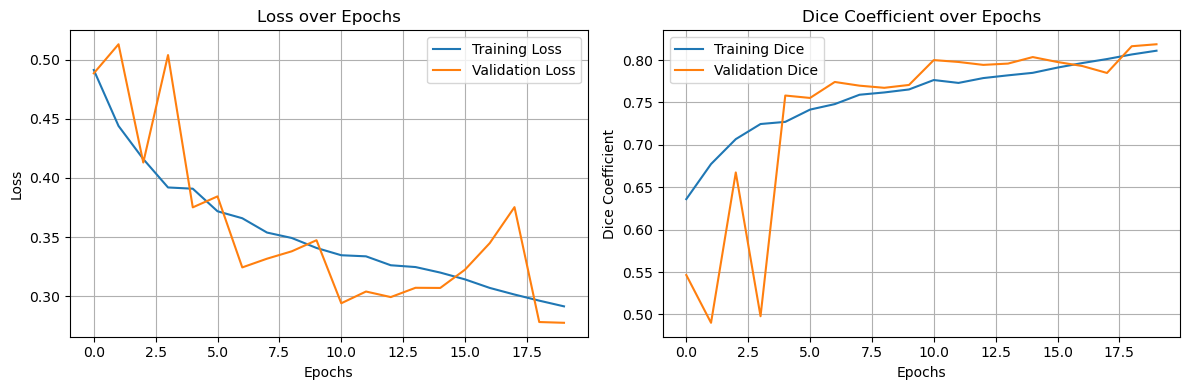

In [15]:
import matplotlib.pyplot as plt

# Visualize training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Dice coefficient
plt.subplot(1, 2, 2)
plt.plot(history['train_dice'], label='Training Dice')
plt.plot(history['val_dice'], label='Validation Dice')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
# Load the best model
best_model = UNet(in_channels=3, out_channels=1).to(device)
best_model.load_state_dict(torch.load('best_model.pt'))
best_model.eval()  # Set to evaluation mode

# Evaluate on test set
test_loss = 0.0
test_dice = 0.0

with torch.no_grad():  # Disable gradient calculation
    for inputs, masks in tqdm(test_loader, desc='Testing'):
        inputs = inputs.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = best_model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, masks)
        
        # Calculate Dice coefficient
        pred = torch.sigmoid(outputs) > 0.5
        dice = dice_coefficient(pred.float(), masks)
        
        # Accumulate metrics
        test_loss += loss.item() * inputs.size(0)
        test_dice += dice.item() * inputs.size(0)

# Calculate final metrics
test_loss = test_loss / len(test_loader.dataset)
test_dice = test_dice / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Dice Coefficient: {test_dice:.4f}')


Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Test Loss: 0.3093
Test Dice Coefficient: 0.8092


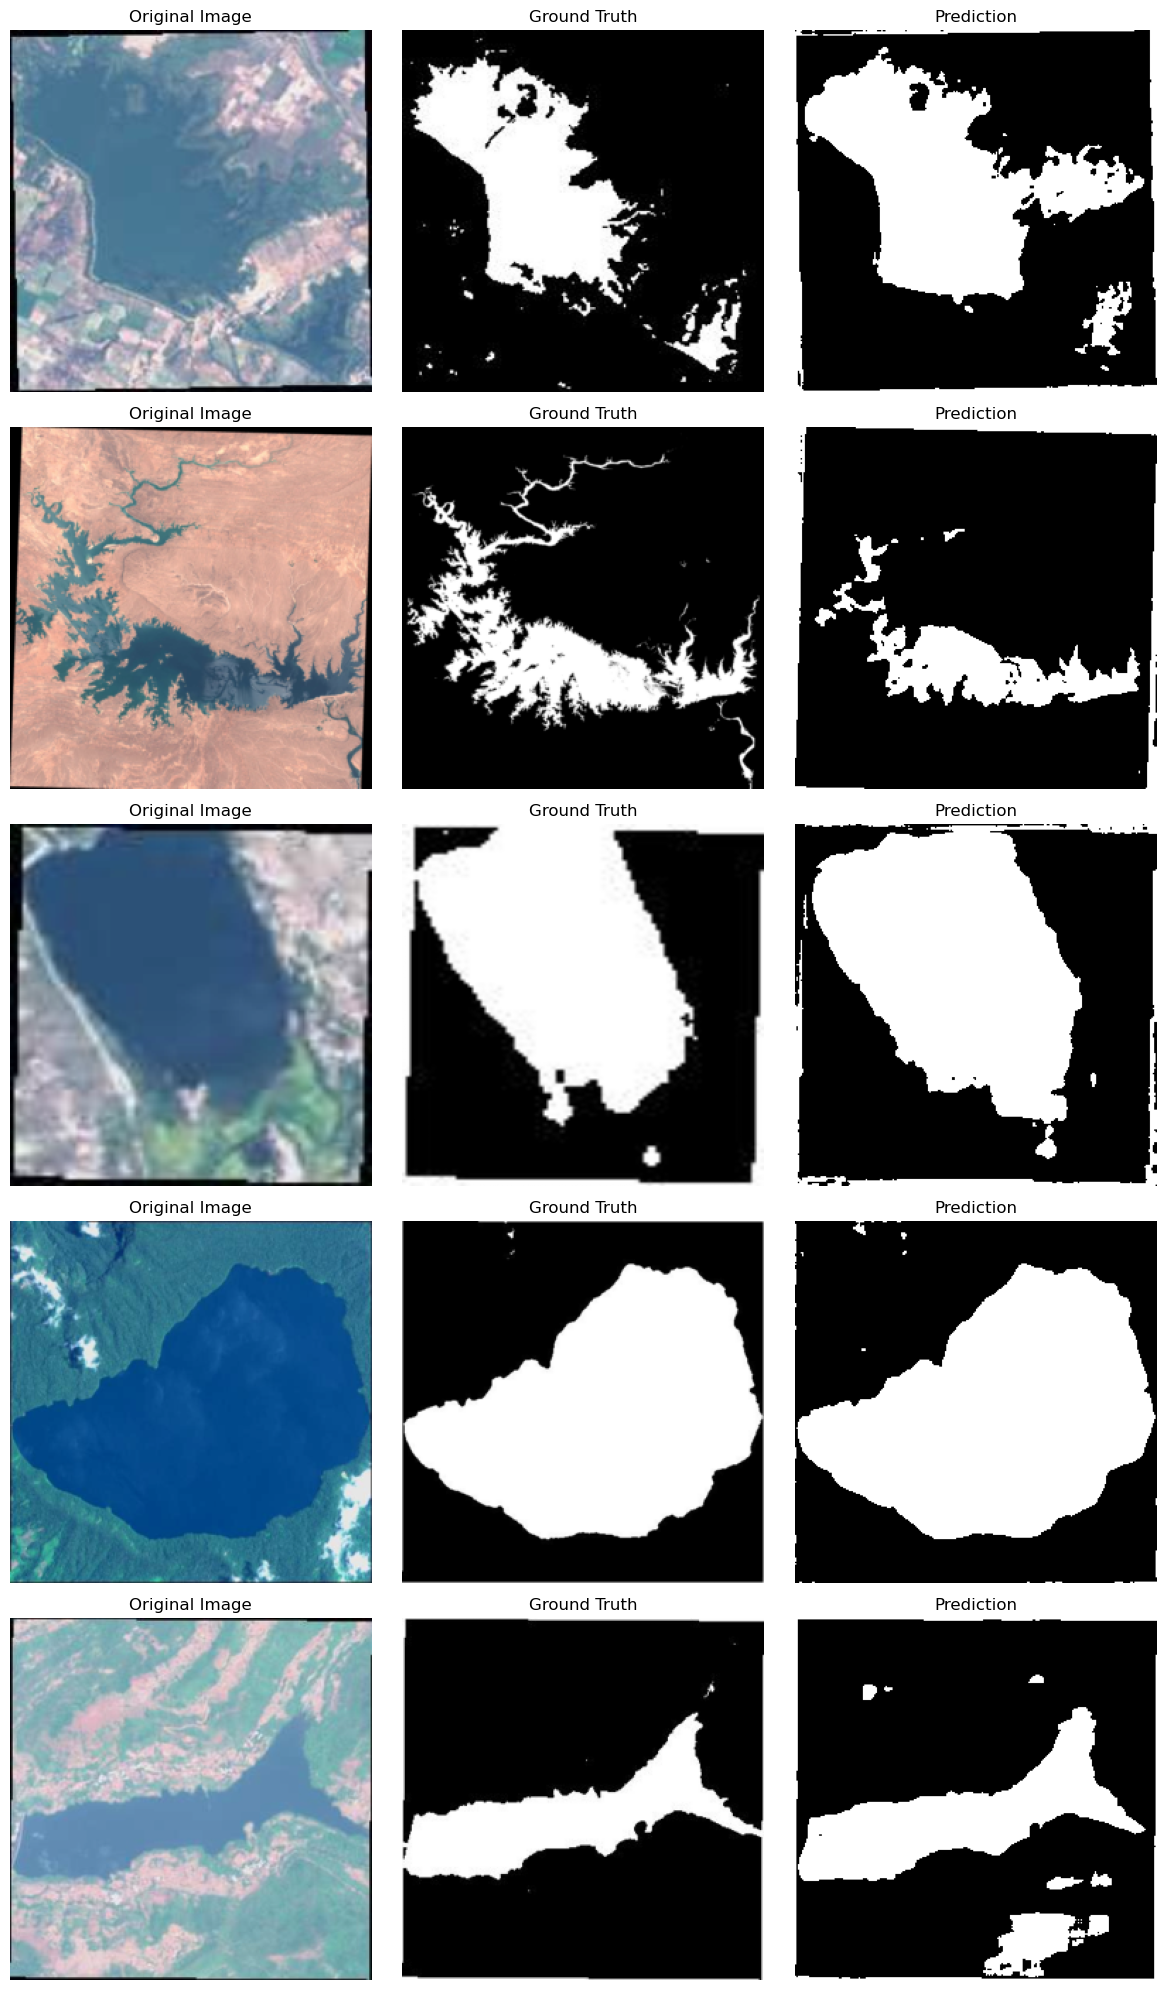

In [17]:
def visualize_predictions(model, dataloader, num_samples=5, device='cuda'):
    """
    Visualize model predictions compared to ground truth
    """
    model.eval()  # Set model to evaluation mode
    
    # Get a batch of test images
    dataiter = iter(dataloader)
    images, masks = next(dataiter)
    
    # Make predictions
    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5
    
    # Visualize results
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
        
    for i in range(min(num_samples, len(images))):
        # Original image
        img = images[i].cpu().permute(1, 2, 0).numpy()  # Change from (C,H,W) to (H,W,C)
        # If image was normalized between -1 and 1
        img = (img - img.min()) / (img.max() - img.min())  
        
        # Ground truth mask
        mask = masks[i].cpu().squeeze().numpy()
        
        # Predicted mask
        pred = preds[i].cpu().squeeze().numpy()
        
        # Display
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
visualize_predictions(best_model, test_loader, num_samples=5, device=device)


In [2]:
visualize_predictions(best_model, test_loader, num_samples=5, device=device)


NameError: name 'visualize_predictions' is not defined